In [1]:
# load the data

import os
import glob 
from matplotlib.pyplot import rc_context
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

import pickle  #upper threshold 값들을 저장하고 불러오기 위해서.

In [4]:
# Load the stored data object
save_file = './data/results/qc_tutorial_2.h5ad'
adata = sc.read_h5ad(save_file)


In [5]:
adata2 = adata.raw.to_adata()   #logtransformed and normalized 


In [6]:
adata

AnnData object with n_obs × n_vars = 32478 × 4313
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'n_genes'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
# check that the matrix looks like noramlized counts
print(adata2.X[1:10,1:10])


  (0, 8)	1.5870976
  (2, 8)	1.0337517
  (3, 6)	1.1536268
  (4, 7)	0.40967566
  (5, 6)	1.5439905
  (6, 6)	0.5927901
  (6, 8)	0.3396916


In [8]:
var_genes_all = adata.var.highly_variable

In [9]:
print("Highly variable genes: %d"%sum(var_genes_all))


Highly variable genes: 4313


In [10]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')


extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [11]:
print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))


Highly variable genes intersection: 6


In [12]:
print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

Number of batches where gene is variable:
0     4610
1     2355
4     2067
2     2020
3     1947
5     1946
6     1879
7     1612
8     1419
9     1098
10     757
11     550
12     333
13     222
14     140
15      86
16      54
17      31
18      12
19       6
Name: highly_variable_nbatches, dtype: int64


In [14]:
var_genes_batch = adata2.var.highly_variable_nbatches > 0


In [15]:
print("Any batch var genes: %d"%sum(var_genes_batch))


Any batch var genes: 18534


In [16]:
print("All data var genes: %d"%sum(var_genes_all))


All data var genes: 4313


In [17]:
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))


Overlap: 4302


In [18]:
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 19))


Variable genes in all batches: 6


In [19]:
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Overlap batch instersection and all: 6


In [22]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]


len(var_genes)

14159

In [23]:
var_select[1:10]

AC114498.1    False
AL669831.2    False
FAM87B        False
LINC00115      True
FAM41C         True
AL645608.2    False
SAMD11         True
NOC2L          True
KLHL17         True
Name: highly_variable_nbatches, dtype: bool

In [25]:
var_select.index


Index(['AL627309.1', 'AC114498.1', 'AL669831.2', 'FAM87B', 'LINC00115',
       'FAM41C', 'AL645608.2', 'SAMD11', 'NOC2L', 'KLHL17',
       ...
       'AC145212.1', 'MAFIP', 'AC011043.1', 'AL354822.1', 'AL592183.1',
       'AC240274.1', 'AC136612.1', 'AC136616.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=23144)

In [26]:
var_select

AL627309.1    False
AC114498.1    False
AL669831.2    False
FAM87B        False
LINC00115      True
              ...  
AC240274.1    False
AC136612.1    False
AC136616.1     True
AC007325.4     True
AC007325.2    False
Name: highly_variable_nbatches, Length: 23144, dtype: bool

In [29]:
type(var_select)

pandas.core.series.Series

In [30]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

alldata    

{'OC4': View of AnnData object with n_obs × n_vars = 920 × 23144
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'n_genes'
     var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'hvg', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
     obsm: 'X_pca', 'X_tsne', 'X_umap', 'spatial',
 'OC10': View of AnnData object with n_obs × n_vars = 1737 × 23144
     obs:

In [32]:
alldata2 = dict()

In [33]:
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

OC4
OC10
OC12
OC15
SING_52
SING_56
SING_57
SING_60
SING_62
SING_64
SING_65
SING_67
SING_68
SING_69
SING_71
SING_72
SING_74
SING_76
SING_77


In [35]:
#convert to list of AnnData objects
adatas = list(alldata2.values())


In [37]:
type(adatas)

list

In [39]:
len(alldata2.values())

19

In [42]:
import scanorama


In [43]:
# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 14159 genes among all datasets
[[0.00000000e+00 1.84782609e-02 1.32223310e-02 9.78260870e-03
  9.89130435e-02 2.17391304e-02 3.04347826e-02 0.00000000e+00
  3.26086957e-03 1.19565217e-02 5.00000000e-02 8.69565217e-03
  7.39130435e-02 1.08695652e-03 1.41304348e-02 1.39471285e-01
  1.10738255e-01 2.05434783e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.62061025e-02 0.00000000e+00
  2.97239915e-03 1.19746690e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.82033097e-01 8.11688312e-04 0.00000000e+00
  8.05987334e-03 0.00000000e+00 0.00000000e+00 2.87852619e-03
  6.30872483e-02 3.62694301e-02 3.03766707e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66503428e-02
  9.34182590e-03 5.07292327e-03 4.62215701e-02 1.81194907e-02
  8.09386973e-02 1.18203310e-03 6.49350649e-03 7.34573947e-03
  1.12589560e-02 0.00000000e+00 4.69238790e-03 4.79921645e-02
  0.00000000e+00 1.21939275e-01 6.07533414e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.20806794e

In [44]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.

adatas[0].obsm['X_scanorama'].shape

(920, 50)

In [45]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

In [47]:
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)


(32478, 50)


In [48]:
# add to the AnnData object
adata.obsm["Scanorama"] = all_s

In [49]:
# tsne and umap
sc.pp.neighbors(adata, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = 50, use_rep = "Scanorama")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
computing tSNE
    using sklearn.manifold.TSNE


/home/ubuntu/pyenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:50)


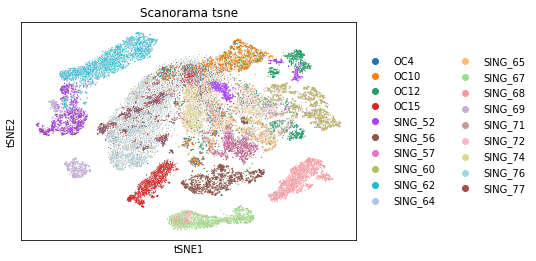

In [50]:
sc.pl.tsne(adata, color="sample", title="Scanorama tsne")

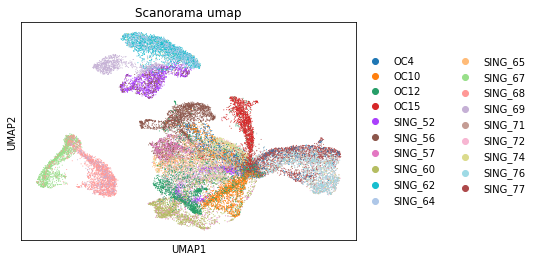

In [51]:
sc.pl.umap(adata, color="sample", title="Scanorama umap")
